In [4]:
# -*- coding: utf-8 -*-
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import random
import math

import sklearn
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier


dataDP1 = sio.loadmat('drug_post1.mat')
dataPB = sio.loadmat('placebo_post.mat')

listDP1ReadDict = dataDP1['drug_post1']
listPBReadDict = dataPB['placebo_post']

listDP1ReadDict = listDP1ReadDict.transpose()
listPBReadDict = listPBReadDict.transpose()

def cut_to_2800(npList):
    temp = []
    for i in range(npList.shape[0]):
        temp.append(npList[i][0][0])
    for i in range(npList.shape[0]):
        temp[i] = temp[i][: 2700, : , :]
    temp = np.array(temp)
    #print(temp)
    return temp

listDP1 = cut_to_2800(listDP1ReadDict)
listPB = cut_to_2800(listPBReadDict)


def extract_One_Two(list):
    temp1 = []
    temp2 = []
    for i in range(list.shape[0]):
        temp1.append(list[i][:, 0, :])
        temp2.append(list[i][:, 1, :])
    temp1 = np.array(temp1)
    temp2 = np.array(temp2)
    return (temp1, temp2)

[listDP1_1st, listDP1_2nd] = extract_One_Two(listDP1)
[listPB_1st, listPB_2nd] = extract_One_Two(listPB)

print(listDP1_1st.shape)
print(listPB_1st.shape)


(25, 2700, 20)
(61, 2700, 20)


## 100 X 2000

In [5]:
def split_to_validation_test(list1, list0): #list1: X with 1, list0: X with 0
    valid = []
    test = []
    valid_label = []
    test_label = []
    
    valid_1 = 0.05
    valid_0 = 0.05
    test_1 = 0.15
    test_0 = 0.15
    
    dict_1 = {}
    upperbound_1 = 0
            
    while upperbound_1 < math.ceil(valid_1 * len(list1)):
        cur = random.randint(0, len(list1) - 1)
        if cur not in dict_1:
            valid.append(list1[cur])
            valid_label.append(1)
            dict_1[cur] = 'valid'
            upperbound_1 += 1
            
    upperbound_1 = 0
    while upperbound_1 < math.ceil(test_1 * len(list1)):
        cur = random.randint(0, len(list1) - 1)
        if cur not in dict_1:
            test.append(list1[cur])
            test_label.append(1)
            dict_1[cur] = 'test'
            upperbound_1 += 1
            
            
    dict_0 = {}
    upperbound_0 = 0
    while upperbound_0 < math.ceil(valid_0 * len(list0)):
        cur = random.randint(0, len(list0) - 1)
        if cur not in dict_0:
            valid.append(list0[cur])
            valid_label.append(0)
            dict_0[cur] = 'valid'
            upperbound_0 += 1
            
    upperbound_0 = 0
    while upperbound_0 < math.ceil(test_0 * len(list0)):
        cur = random.randint(0, len(list0) - 1)
        if cur not in dict_0:
            test.append(list0[cur])
            test_label.append(0)
            dict_0[cur] = 'test'
            upperbound_0 += 1
            
    # Split traning data from two dict record:
    training = []
    training_label = []
    for x in range(len(list1)):
        if x not in dict_1:
            training.append(list1[x])
            training_label.append(1)

    for x in range(len(list0)):
        if x not in dict_0:
            training.append(list0[x])
            training_label.append(0)
           
    training = np.array(training)    
    training_label = np.array(training_label) 
    
    valid = np.array(valid)
    test = np.array(test)
    valid_label = np.array(valid_label)
    test_label = np.array(test_label)
    print('traning:')
    print(training.shape)
    print(training_label.shape)
    print('valid:')
    print(valid.shape)
    print(valid_label.shape)
    print('test:')
    print(test.shape)
    print(test_label.shape)
     
    return (training, training_label, valid, valid_label, test, test_label)

t, t_l, v, v_l, test, test_l = split_to_validation_test(listDP1_1st, listPB_1st)

permutation = np.random.permutation(t.shape[0])
t = t[permutation, :]
t_l = t_l[permutation]

permutation = np.random.permutation(v.shape[0])
v = v[permutation, :]
v_l = v_l[permutation]

permutation = np.random.permutation(test.shape[0])
test = test[permutation, :]
test_l = test_l[permutation]

traning:
(66, 2700, 20)
(66,)
valid:
(6, 2700, 20)
(6,)
test:
(14, 2700, 20)
(14,)


In [6]:
def correlation_compute_2D_input(list):
    vetor = []
    corr_matrix = []
    #print(list.shape[0])
    tempCorrMatrix = np.identity(20)
    tempVector = []
    for i in range(20):
        count = 0
        for j in range(20):
            if i == j:
                continue
            temp = np.corrcoef(list[:,i],  list[:,j])
            tempCorrMatrix[i][j] = temp[0][1]
            if count < i:
                tempVector.append(temp[0][1])
                count += 1
    vetor.append(tempVector)
    corr_matrix.append(tempCorrMatrix)
    vetor = np.array(vetor)
    corr_matrix = np.array(corr_matrix)
    return (vetor, corr_matrix)


def aug_data(list, label, num_windows, len_windows):
    step = int((2700 - len_windows) / num_windows) # step for each sliding
    aug_list = []
    print('Processing Data Aug')
    for i in range(list.shape[0]): # number of subjects
        indiv = []
        for j in range(num_windows):
            temp = list[i][j * step : len_windows + j * step, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            indiv.append(vec.tolist())
        aug_list.append(indiv)
        if i % 10 == 0:
            print(i)
    aug_list = np.array(aug_list)      
    return (aug_list)


aug_t = aug_data(t, t_l, 100, 2000)
aug_v = aug_data(v, v_l, 100, 2000)
aug_test= aug_data(test, test_l, 100, 2000)


Processing Data Aug
0
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
10
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
20
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
30
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
40
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Processing Data Aug
Proces

In [7]:
print(aug_t.shape)
print(t_l.shape)
print(aug_v.shape)
print(v_l.shape)
print(aug_test.shape)
print(test_l.shape)

sq_aug_t = np.squeeze(aug_t)
sq_aug_v = np.squeeze(aug_v)
sq_aug_test = np.squeeze(aug_test)

print(sq_aug_t.shape)
print(sq_aug_v.shape)
print(sq_aug_test.shape)

(66, 100, 1, 190)
(66,)
(6, 100, 1, 190)
(6,)
(14, 100, 1, 190)
(14,)
(66, 100, 190)
(6, 100, 190)
(14, 100, 190)


(14, 100, 190)

Compiling...

Train on 66 samples, validate on 6 samples
Epoch 1/15
66/66 [==============================] - 4s 53ms/step - loss: 0.8253 - acc: 0.5606 - val_loss: 0.7147 - val_acc: 0.6667
Epoch 2/15
66/66 [==============================] - 2s 37ms/step - loss: 0.6687 - acc: 0.7121 - val_loss: 0.7417 - val_acc: 0.6667
Epoch 3/15
66/66 [==============================] - 2s 37ms/step - loss: 0.6537 - acc: 0.7121 - val_loss: 0.7080 - val_acc: 0.6667
Epoch 4/15
66/66 [==============================] - 2s 37ms/step - loss: 0.5848 - acc: 0.7121 - val_loss: 0.6962 - val_acc: 0.6667
Epoch 5/15
66/66 [==============================] - 2s 36ms/step - loss: 0.5781 - acc: 0.7424 - val_loss: 0.7856 - val_acc: 0.6667
Epoch 6/15
66/66 [==============================] - 2s 37ms/step - loss: 0.5732 - acc: 0.7273 - val_loss: 0.7270 - val_acc: 0.6667
Epoch 7/15
66/66 [==============================] - 2s 36ms/step - loss: 0.5326 - acc: 0.7424 - val_loss: 0.6911 - val_acc: 0.6667
Epoch 8/15

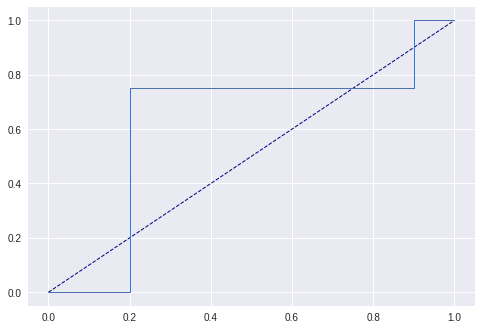

In [16]:
import time
import csv
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
from keras.layers import Masking, Embedding
import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing 

X_train = np.arctanh(sq_aug_t)
#X_train = sq_aug_t
y_train = t_l

X_test = np.arctanh(sq_aug_test)
#X_test = sq_aug_test
y_test = test_l

X_valid = np.arctanh(sq_aug_v)
#X_valid = sq_aug_v
y_valid = v_l

def build_model():
    model = Sequential()
    layers = [0, 190, 190, 1]
    
    #input_dim=190, input_length=100
    #keras.layers.BatchNormalization()
    model.add(LSTM(layers[1], input_shape=(100, 190), return_sequences=False))
    model.add(Dropout(0.2))
    #keras.layers.BatchNormalization()
    #model.add(LSTM(layers[2], return_sequences=False))
    #model.add(Dropout(0.2))
    
    '''
    keras.layers.BatchNormalization()
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    '''
    
    #keras.layers.BatchNormalization()
    model.add(Dense(layers[3]))
    model.add(Activation('sigmoid'))
      
    model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy', optimizer="adam")
    return model



def run_network(model=None, data=None):
    epochs = 15
    X_train, y_train, X_test, y_test = data
    print('\nCompiling...\n')
    if model is None:
        model = build_model()
    try:
        model.fit(
            X_train, y_train,
            batch_size=8, epochs=epochs, validation_data=(X_valid, y_valid))
            #batch_size=8, epochs=epochs, validation_data=(X_test, y_test))
        predicted = model.predict(X_test)
        print('Predict:')
        print(predicted)
        print('True label:')
        print(y_test)
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        return model, y_test, 0
    return model, y_test, predicted


model = build_model()
print(X_test.shape)
(trained_model, y_t, pred) = run_network(model, [X_train, y_train, X_test, y_test])


y_pred_keras = model.predict(X_test).ravel()
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_keras, pos_label=1)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1)
plt.show()

## 100 X 1500

0
10
20
30
40
50
60
0
0
10

Compiling...

Train on 66 samples, validate on 6 samples
Epoch 1/15
66/66 [==============================] - 4s 67ms/step - loss: 0.9882 - acc: 0.6212 - val_loss: 0.8513 - val_acc: 0.6667
Epoch 2/15
66/66 [==============================] - 3s 41ms/step - loss: 0.6317 - acc: 0.7121 - val_loss: 0.7315 - val_acc: 0.3333
Epoch 3/15
66/66 [==============================] - 3s 42ms/step - loss: 0.6112 - acc: 0.6818 - val_loss: 0.7886 - val_acc: 0.6667
Epoch 4/15
66/66 [==============================] - 3s 42ms/step - loss: 0.6530 - acc: 0.7121 - val_loss: 0.6949 - val_acc: 0.5000
Epoch 5/15
66/66 [==============================] - 3s 42ms/step - loss: 0.5988 - acc: 0.7424 - val_loss: 0.8658 - val_acc: 0.3333
Epoch 6/15
66/66 [==============================] - 3s 42ms/step - loss: 0.6061 - acc: 0.6818 - val_loss: 0.7154 - val_acc: 0.6667
Epoch 7/15
66/66 [==============================] - 3s 41ms/step - loss: 0.5880 - acc: 0.7273 - val_loss: 0.8106 - val_acc: 0.666

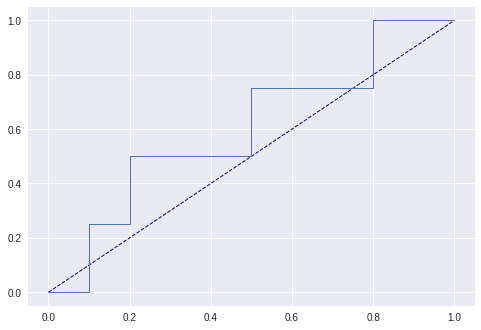

In [17]:
def correlation_compute_2D_input(list):
    vetor = []
    corr_matrix = []
    #print(list.shape[0])
    tempCorrMatrix = np.identity(20)
    tempVector = []
    for i in range(20):
        count = 0
        for j in range(20):
            if i == j:
                continue
            temp = np.corrcoef(list[:,i],  list[:,j])
            tempCorrMatrix[i][j] = temp[0][1]
            if count < i:
                tempVector.append(temp[0][1])
                count += 1
    vetor.append(tempVector)
    corr_matrix.append(tempCorrMatrix)
    vetor = np.array(vetor)
    corr_matrix = np.array(corr_matrix)
    return (vetor, corr_matrix)


def aug_data(list, label, num_windows, len_windows):
    step = int((2700 - len_windows) / num_windows) # step for each sliding
    
    aug_list = []

    for i in range(list.shape[0]): # number of subjects
        indiv = []
        for j in range(num_windows):
            temp = list[i][j * step : len_windows + j * step, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            indiv.append(vec.tolist())
        aug_list.append(indiv)
        if i % 10 == 0:
            print(i)
    aug_list = np.array(aug_list)      
    return (aug_list)


aug_t = aug_data(t, t_l, 100, 1500)
aug_v = aug_data(v, v_l, 100, 1500)
aug_test= aug_data(test, test_l, 100, 1500)

sq_aug_t = np.squeeze(aug_t)
sq_aug_v = np.squeeze(aug_v)
sq_aug_test = np.squeeze(aug_test)



import time
import csv
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
from keras.layers import Masking, Embedding
import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing 

X_train = np.arctanh(sq_aug_t)
#X_train = sq_aug_t
y_train = t_l

X_test = np.arctanh(sq_aug_test)
#X_test = sq_aug_test
y_test = test_l

X_valid = np.arctanh(sq_aug_v)
#X_valid = sq_aug_v
y_valid = v_l

def build_model():
    model = Sequential()
    layers = [0, 190, 190, 1]
    
    #input_dim=190, input_length=100
    keras.layers.BatchNormalization()
    model.add(LSTM(layers[1], input_shape=(100, 190), return_sequences=True))
    model.add(Dropout(0.2))
    #keras.layers.BatchNormalization()
    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(0.2))
    
    '''
    keras.layers.BatchNormalization()
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    '''
    
    #keras.layers.BatchNormalization()
    model.add(Dense(layers[3]))
    model.add(Activation('sigmoid'))
      
    model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy', optimizer="adam")
    return model



def run_network(model=None, data=None):
    epochs = 15
    X_train, y_train, X_test, y_test = data
    print('\nCompiling...\n')
    if model is None:
        model = build_model()
    try:
        model.fit(
            X_train, y_train,
            batch_size=16, epochs=epochs, validation_data=(X_valid, y_valid))
        predicted = model.predict(X_test)
        print('Predict:')
        print(predicted)
        print('True label:')
        print(y_test)
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        return model, y_test, 0
    return model, y_test, predicted


model = build_model()
(trained_model, y_t, pred) = run_network(model, [X_train, y_train, X_test, y_test])


y_pred_keras = model.predict(X_test).ravel()
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_keras, pos_label=1)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1)
plt.show()

## 9 * 300

0
10
20
30
40
50
60
0
0
10

Compiling...

Train on 66 samples, validate on 6 samples
Epoch 1/15
66/66 [==============================] - 4s 59ms/step - loss: 0.7646 - acc: 0.6212 - val_loss: 0.6546 - val_acc: 0.6667
Epoch 2/15
66/66 [==============================] - 0s 5ms/step - loss: 0.6309 - acc: 0.6970 - val_loss: 0.6528 - val_acc: 0.6667
Epoch 3/15
66/66 [==============================] - 0s 5ms/step - loss: 0.5599 - acc: 0.7121 - val_loss: 0.6734 - val_acc: 0.6667
Epoch 4/15
66/66 [==============================] - 0s 5ms/step - loss: 0.5711 - acc: 0.7424 - val_loss: 0.7006 - val_acc: 0.6667
Epoch 5/15
66/66 [==============================] - 0s 5ms/step - loss: 0.5785 - acc: 0.7121 - val_loss: 0.7141 - val_acc: 0.6667
Epoch 6/15
66/66 [==============================] - 0s 5ms/step - loss: 0.6335 - acc: 0.5758 - val_loss: 0.7507 - val_acc: 0.6667
Epoch 7/15
66/66 [==============================] - 0s 5ms/step - loss: 0.5594 - acc: 0.7424 - val_loss: 0.8202 - val_acc: 0.6667
Epoc

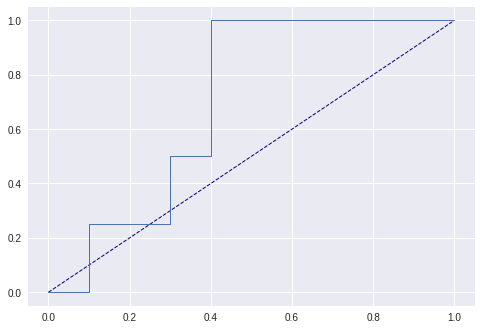

In [26]:
def correlation_compute_2D_input(list):
    vetor = []
    corr_matrix = []
    #print(list.shape[0])
    tempCorrMatrix = np.identity(20)
    tempVector = []
    for i in range(20):
        count = 0
        for j in range(20):
            if i == j:
                continue
            temp = np.corrcoef(list[:,i],  list[:,j])
            tempCorrMatrix[i][j] = temp[0][1]
            if count < i:
                tempVector.append(temp[0][1])
                count += 1
    vetor.append(tempVector)
    corr_matrix.append(tempCorrMatrix)
    vetor = np.array(vetor)
    corr_matrix = np.array(corr_matrix)
    return (vetor, corr_matrix)


def aug_data(list, label, num_windows, len_windows):
    step = int((2700 - len_windows) / num_windows) # step for each sliding
    
    aug_list = []

    for i in range(list.shape[0]): # number of subjects
        indiv = []
        for j in range(num_windows):
            temp = list[i][j * step : len_windows + j * step, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            indiv.append(vec.tolist())
        aug_list.append(indiv)
        if i % 10 == 0:
            print(i)
    aug_list = np.array(aug_list)      
    return (aug_list)


aug_t = aug_data(t, t_l, 9, 300)
aug_v = aug_data(v, v_l, 9, 300)
aug_test= aug_data(test, test_l, 9, 300)

sq_aug_t = np.squeeze(aug_t)
sq_aug_v = np.squeeze(aug_v)
sq_aug_test = np.squeeze(aug_test)



import time
import csv
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
from keras.layers import Masking, Embedding
import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing 

X_train = np.arctanh(sq_aug_t)
#X_train = sq_aug_t
y_train = t_l

X_test = np.arctanh(sq_aug_test)
#X_test = sq_aug_test
y_test = test_l

X_valid = np.arctanh(sq_aug_v)
#X_valid = sq_aug_v
y_valid = v_l

def build_model():
    model = Sequential()
    layers = [0, 190, 190, 1]
    
    #input_dim=190, input_length=100
    keras.layers.BatchNormalization()
    model.add(LSTM(layers[1], input_shape=(9, 190), return_sequences=True))
    model.add(Dropout(0.2))
    #keras.layers.BatchNormalization()
    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(0.2))
    
    '''
    keras.layers.BatchNormalization()
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    '''
    
    #keras.layers.BatchNormalization()
    model.add(Dense(layers[3]))
    model.add(Activation('sigmoid'))
      
    model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy', optimizer="adam")
    return model



def run_network(model=None, data=None):
    epochs = 15
    X_train, y_train, X_test, y_test = data
    print('\nCompiling...\n')
    if model is None:
        model = build_model()
    try:
        model.fit(
            X_train, y_train,
            batch_size=16, epochs=epochs, validation_data=(X_valid, y_valid))
        predicted = model.predict(X_test)
        print('Predict:')
        print(predicted)
        print('True label:')
        print(y_test)
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        return model, y_test, 0
    return model, y_test, predicted


model = build_model()
(trained_model, y_t, pred) = run_network(model, [X_train, y_train, X_test, y_test])


y_pred_keras = model.predict(X_test).ravel()
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_keras, pos_label=1)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1)
plt.show()

## 50 * 1500

0
10
20
30
40
50
60
0
0
10

Compiling...

Train on 66 samples, validate on 6 samples
Epoch 1/15
66/66 [==============================] - 7s 108ms/step - loss: 0.6647 - acc: 0.6970 - val_loss: 0.6480 - val_acc: 0.6667
Epoch 2/15
66/66 [==============================] - 3s 42ms/step - loss: 0.6979 - acc: 0.7424 - val_loss: 0.7254 - val_acc: 0.3333
Epoch 3/15
66/66 [==============================] - 3s 42ms/step - loss: 0.5916 - acc: 0.7121 - val_loss: 0.7962 - val_acc: 0.6667
Epoch 4/15
66/66 [==============================] - 3s 40ms/step - loss: 0.6033 - acc: 0.6667 - val_loss: 0.8439 - val_acc: 0.6667
Epoch 5/15
66/66 [==============================] - 3s 43ms/step - loss: 0.5786 - acc: 0.7273 - val_loss: 0.6437 - val_acc: 0.6667
Epoch 6/15
66/66 [==============================] - 3s 43ms/step - loss: 0.5464 - acc: 0.7576 - val_loss: 1.5413 - val_acc: 0.3333
Epoch 7/15
66/66 [==============================] - 3s 43ms/step - loss: 0.8767 - acc: 0.6061 - val_loss: 0.7778 - val_acc: 0.66

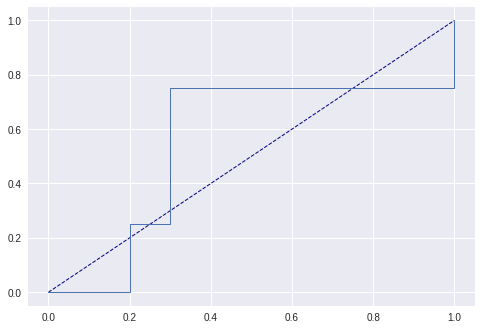

In [22]:
def correlation_compute_2D_input(list):
    vetor = []
    corr_matrix = []
    #print(list.shape[0])
    tempCorrMatrix = np.identity(20)
    tempVector = []
    for i in range(20):
        count = 0
        for j in range(20):
            if i == j:
                continue
            temp = np.corrcoef(list[:,i],  list[:,j])
            tempCorrMatrix[i][j] = temp[0][1]
            if count < i:
                tempVector.append(temp[0][1])
                count += 1
    vetor.append(tempVector)
    corr_matrix.append(tempCorrMatrix)
    vetor = np.array(vetor)
    corr_matrix = np.array(corr_matrix)
    return (vetor, corr_matrix)


def aug_data(list, label, num_windows, len_windows):
    step = int((2700 - len_windows) / num_windows) # step for each sliding
    
    aug_list = []

    for i in range(list.shape[0]): # number of subjects
        indiv = []
        for j in range(num_windows):
            temp = list[i][j * step : len_windows + j * step, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            indiv.append(vec.tolist())
        aug_list.append(indiv)
        if i % 10 == 0:
            print(i)
    aug_list = np.array(aug_list)      
    return (aug_list)


aug_t = aug_data(t, t_l, 50, 1500)
aug_v = aug_data(v, v_l, 50, 1500)
aug_test= aug_data(test, test_l, 50, 1500)

sq_aug_t = np.squeeze(aug_t)
sq_aug_v = np.squeeze(aug_v)
sq_aug_test = np.squeeze(aug_test)



import time
import csv
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
from keras.layers import Masking, Embedding
import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing 

X_train = np.arctanh(sq_aug_t)
#X_train = sq_aug_t
y_train = t_l

X_test = np.arctanh(sq_aug_test)
#X_test = sq_aug_test
y_test = test_l

X_valid = np.arctanh(sq_aug_v)
#X_valid = sq_aug_v
y_valid = v_l

def build_model():
    model = Sequential()
    layers = [0, 190, 190, 1]
    
    #input_dim=190, input_length=100
    keras.layers.BatchNormalization()
    model.add(LSTM(layers[1], input_shape=(50, 190), return_sequences=True))
    model.add(Dropout(0.2))
    #keras.layers.BatchNormalization()
    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(0.2))
    
    '''
    keras.layers.BatchNormalization()
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    '''
    
    #keras.layers.BatchNormalization()
    model.add(Dense(layers[3]))
    model.add(Activation('sigmoid'))
      
    model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy', optimizer="adam")
    return model



def run_network(model=None, data=None):
    epochs = 15
    X_train, y_train, X_test, y_test = data
    print('\nCompiling...\n')
    if model is None:
        model = build_model()
    try:
        model.fit(
            X_train, y_train,
            batch_size=16, epochs=epochs, validation_data=(X_valid, y_valid))
        predicted = model.predict(X_test)
        print('Predict:')
        print(predicted)
        print('True label:')
        print(y_test)
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        return model, y_test, 0
    return model, y_test, predicted


model = build_model()
(trained_model, y_t, pred) = run_network(model, [X_train, y_train, X_test, y_test])


y_pred_keras = model.predict(X_test).ravel()
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_keras, pos_label=1)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1)
plt.show()

## 50 * 2000

0
10
20
30
40
50
60
0
0
10

Compiling...

Train on 66 samples, validate on 6 samples
Epoch 1/15
66/66 [==============================] - 4s 62ms/step - loss: 0.9926 - acc: 0.7273 - val_loss: 0.8597 - val_acc: 0.6667
Epoch 2/15
66/66 [==============================] - 1s 21ms/step - loss: 0.6610 - acc: 0.7121 - val_loss: 0.7316 - val_acc: 0.6667
Epoch 3/15
66/66 [==============================] - 1s 21ms/step - loss: 0.6200 - acc: 0.7121 - val_loss: 0.6424 - val_acc: 0.6667
Epoch 4/15
66/66 [==============================] - 1s 21ms/step - loss: 0.6058 - acc: 0.7121 - val_loss: 0.7604 - val_acc: 0.6667
Epoch 5/15
66/66 [==============================] - 1s 21ms/step - loss: 0.6097 - acc: 0.7273 - val_loss: 0.6594 - val_acc: 0.6667
Epoch 6/15
66/66 [==============================] - 1s 21ms/step - loss: 0.6547 - acc: 0.5606 - val_loss: 0.7901 - val_acc: 0.6667
Epoch 7/15
66/66 [==============================] - 1s 21ms/step - loss: 0.6260 - acc: 0.7121 - val_loss: 0.7277 - val_acc: 0.666

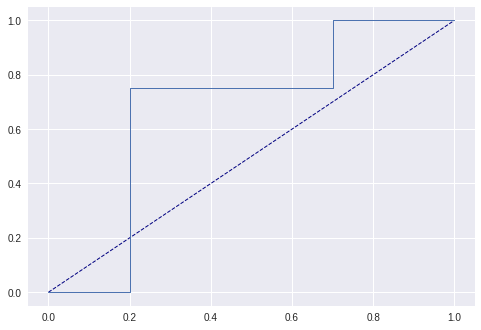

In [23]:
def correlation_compute_2D_input(list):
    vetor = []
    corr_matrix = []
    #print(list.shape[0])
    tempCorrMatrix = np.identity(20)
    tempVector = []
    for i in range(20):
        count = 0
        for j in range(20):
            if i == j:
                continue
            temp = np.corrcoef(list[:,i],  list[:,j])
            tempCorrMatrix[i][j] = temp[0][1]
            if count < i:
                tempVector.append(temp[0][1])
                count += 1
    vetor.append(tempVector)
    corr_matrix.append(tempCorrMatrix)
    vetor = np.array(vetor)
    corr_matrix = np.array(corr_matrix)
    return (vetor, corr_matrix)


def aug_data(list, label, num_windows, len_windows):
    step = int((2700 - len_windows) / num_windows) # step for each sliding
    
    aug_list = []

    for i in range(list.shape[0]): # number of subjects
        indiv = []
        for j in range(num_windows):
            temp = list[i][j * step : len_windows + j * step, :]
            [vec, temp___] = correlation_compute_2D_input(temp)
            indiv.append(vec.tolist())
        aug_list.append(indiv)
        if i % 10 == 0:
            print(i)
    aug_list = np.array(aug_list)      
    return (aug_list)


aug_t = aug_data(t, t_l, 50, 2000)
aug_v = aug_data(v, v_l, 50, 2000)
aug_test= aug_data(test, test_l, 50, 2000)

sq_aug_t = np.squeeze(aug_t)
sq_aug_v = np.squeeze(aug_v)
sq_aug_test = np.squeeze(aug_test)



import time
import csv
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
from keras.layers import Masking, Embedding
import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing 

X_train = np.arctanh(sq_aug_t)
#X_train = sq_aug_t
y_train = t_l

X_test = np.arctanh(sq_aug_test)
#X_test = sq_aug_test
y_test = test_l

X_valid = np.arctanh(sq_aug_v)
#X_valid = sq_aug_v
y_valid = v_l

def build_model():
    model = Sequential()
    layers = [0, 190, 190, 1]
    
    #input_dim=190, input_length=100
    keras.layers.BatchNormalization()
    model.add(LSTM(layers[1], input_shape=(50, 190), return_sequences=True))
    model.add(Dropout(0.2))
    #keras.layers.BatchNormalization()
    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(0.2))
    
    '''
    keras.layers.BatchNormalization()
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    '''
    
    #keras.layers.BatchNormalization()
    model.add(Dense(layers[3]))
    model.add(Activation('sigmoid'))
      
    model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy', optimizer="adam")
    return model



def run_network(model=None, data=None):
    epochs = 15
    X_train, y_train, X_test, y_test = data
    print('\nCompiling...\n')
    if model is None:
        model = build_model()
    try:
        model.fit(
            X_train, y_train,
            batch_size=16, epochs=epochs, validation_data=(X_valid, y_valid))
        predicted = model.predict(X_test)
        print('Predict:')
        print(predicted)
        print('True label:')
        print(y_test)
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        return model, y_test, 0
    return model, y_test, predicted


model = build_model()
(trained_model, y_t, pred) = run_network(model, [X_train, y_train, X_test, y_test])


y_pred_keras = model.predict(X_test).ravel()
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_keras, pos_label=1)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot(fpr, tpr, lw=1)
plt.show()